<a href="https://colab.research.google.com/github/bantee-sharma/Spam_Classifier_Using_BERT/blob/main/Spam_Classifier_Using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
# Import libraries
import os,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/spam-emails")

print("Path to dataset files:", path)

100%|██████████| 207k/207k [00:00<00:00, 64.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/abdallahwagih/spam-emails/versions/1


In [4]:
# Dataset loading
dataset = path

file_name = os.listdir(dataset)
print(file_name)

data = os.path.join(dataset,"spam.csv")
df = pd.read_csv(data)

df.head()

['spam.csv']


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df["Category"].value_counts()

,count
Category,
ham,4825
spam,747


In [7]:
#Checking for dulicate values
df.duplicated().sum()

np.int64(415)

In [8]:
#Drop duplicate values
df.drop_duplicates(inplace=True)

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
# Convert the "Category" column to numerical labels
df["type"] = df["Category"].map({"ham":0,"spam":1})

In [11]:
# Text cleaning
def clean_sent(sent):
    text = sent.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


In [12]:
# Applying clean func
df["message"] = df["Message"].apply(clean_sent)

In [13]:
df.head()

,Category,Message,type,message
0,ham,"Go until jurong point, crazy.. Available only ...",0,"go until jurong point, crazy.. available only ..."
1,ham,Ok lar... Joking wif u oni...,0,ok lar... joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in a wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor... u c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,"nah i don't think he goes to usf, he lives aro..."


In [14]:
# Drop unnecessary columns
df.drop(["Category","Message"],inplace=True,axis=1)

In [15]:
# Split data
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(df["message"],df["type"],test_size=0.20,random_state=7)

In [16]:
xtrain.shape,ytrain.shape

((4125,), (4125,))

In [17]:
# Convert to list
xtrain_list = xtrain.tolist()
xtest_list = xtest.tolist()

In [18]:
from transformers import AutoTokenizer

In [19]:
# Load the pre-trained BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
# Tokenize the training and testing text data using the BERT tokenizer
xtrain_tokenize = tokenizer(xtrain_list,padding=True,truncation=True,max_length=150,return_tensors="tf")
xtest_tokenize = tokenizer(xtest_list,padding=True,truncation=True,max_length=150,return_tensors="tf")

In [21]:
# Convert to tensors
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(xtrain_tokenize),
    tf.convert_to_tensor(ytrain,dtype = tf.int32)
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(xtest_tokenize),
    tf.convert_to_tensor(ytest,dtype = tf.int32)
)).batch(16)

In [22]:
from transformers import TFBertForSequenceClassification

In [23]:
# Load the pre-trained BERT model for sequence classification (Binary Classification)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=1)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
#  Define the optimizer and loss for training
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
# Model Compiling
model.compile(optimizer=optimizer,loss=loss,metrics=["accuracy"])

In [26]:
# trian model
history = model.fit(train_dataset,epochs=3,validation_data=test_dataset)

Epoch 1/3
258/258 [==============================] - 182s 514ms/step - loss: 0.1668 - accuracy: 0.9505 - val_loss: 0.0723 - val_accuracy: 0.9748
Epoch 2/3
258/258 [==============================] - 131s 507ms/step - loss: 0.0387 - accuracy: 0.9910 - val_loss: 0.0464 - val_accuracy: 0.9855
Epoch 3/3
258/258 [==============================] - 133s 516ms/step - loss: 0.0234 - accuracy: 0.9949 - val_loss: 0.0447 - val_accuracy: 0.9874


In [27]:
#  Evaluate the model's performance on the test dataset
model.evaluate(test_dataset)

65/65 [==============================] - 12s 185ms/step - loss: 0.0447 - accuracy: 0.9874


[0.044679734855890274, 0.9874030947685242]

In [29]:
# Make predictions on the test dataset
pred = model.predict(test_dataset)

# Extract raw logits from the model output
logits = pred["logits"]

# Convert logits to probabilities using the sigmoid function
prob = tf.sigmoid(logits)

65/65 [==============================] - 17s 186ms/step


In [30]:
prob

<tf.Tensor: shape=(1032, 1), dtype=float32, numpy=
array([[0.9938875 ],
       [0.00205079],
       [0.00181388],
       ...,
       [0.00202579],
       [0.00203057],
       [0.00192535]], dtype=float32)>

In [31]:
# Convert probabilities into binary predictions (0 or 1)
pred = (prob > 0.5).numpy().astype(int)

In [32]:
pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

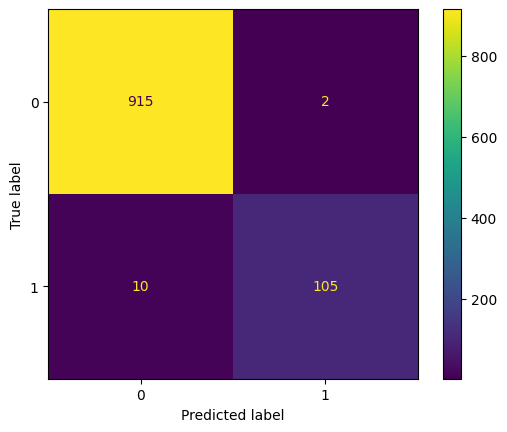

In [34]:
#Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(ytest, pred)

# 📌 Display the confusion matrix visually
ConfusionMatrixDisplay(cm).plot()
# This helps in understanding how well the model distinguishes between classes

In [35]:
def test_model(sent):
  input = tokenizer(sent,padding=True,max_length=150,truncation=True,return_tensors="tf")
  pred = model(input)
  logits = pred.logits
  prob = tf.sigmoid(logits)
  labels = (prob > 0.5).numpy().astype(int)
  return "🔴 Spam" if labels == 1 else "🟢 Not Spam"


In [36]:

sent = "You won a free prize! Click the link to claim."
print(test_model(sent))  # Output: [[1]]  (Spam)

🔴 Spam


In [37]:
test_model('''We are pleased to inform you that you have won $1,000,000 USD in our 2025 International Lottery Draw.
To claim your prize, please provide your:''')

'🔴 Spam'

In [38]:
test_model('''
Subject: Project Meeting Rescheduled
Hi Team,
Due to scheduling conflicts, our project meeting has been rescheduled to Wednesday at 3 PM.
Let me know if this works for everyone.
''')

'🟢 Not Spam'